In [1]:
from IPython.core.display import display, HTML

In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import pg_fitter_tools as fit
import sk_geo_tools as sk
import plotly.graph_objects as go
import pickle

In [5]:
%matplotlib notebook

In [6]:
def plot(data, op, s,c, n):
    return go.Scatter3d(
    x=data[:,0], 
    y=data[:,1], 
    z=data[:,2], 
    marker=go.scatter3d.Marker(size=s,color = c), 
    #marker=dict(
    #        color=c,
    #        size=3,
    #    ), 
    opacity=op, 
    mode='markers',
    name = n)

## Camera Settings

In [7]:
focal_length = np.array([2.760529621789217e+03, 2.767014510543478e+03])
principle_point = np.array([1.914303537872458e+03, 1.596386868474348e+03])
radial_distortion = np.array([-0.2398, 0.1145])
tangential_distortion = np.array([0, 0])

## Load data from files
* Load all PMT locations
* Load image feature locations

In [8]:
all_pmt_locations = fit.read_3d_feature_locations("parameters/SK_all_PMT_locations.txt")
offset = np.array([0, 250])
images = [755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,
          774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,
          793,794,795,796,797,798,799,800,801,901,902,903,904]

imageExtension = ".jpg"
imageLocation = "source/ring_images/"

textLocation = "source/ring_points/"
textExtension = "_labels_all.txt"

saveLocation = "results/full_ring_relabelled/"
image_feature_locations = {}
for image in images:
    image = str(image)
    image_feature_locations.update(
        fit.read_image_feature_locations(
            textLocation+image+textExtension, offset=offset))

## Load fitter from pickle

In [9]:
fitter_old = pickle.load( open( "results/full_ring/SK_ring.pkl", "rb" ) )
reco_locations = {f: fitter_old.reco_locations[i] for f, i in fitter_old.feature_index.items()}
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
common_features = [f for f in feature_counts if feature_counts[f] > 1]
pmt_locations = {k: p for k, p in all_pmt_locations.items() if k in common_features}
errors, reco_transformed, scale, R, translation, location_mean = fit.kabsch_errors(pmt_locations, reco_locations)
camera_orientations, camera_positions = fit.camera_world_poses(fitter_old.camera_rotations, fitter_old.camera_translations)
camera_orientations = np.matmul(R, camera_orientations)
camera_positions = camera_positions - translation
camera_positions = scale*R.dot(camera_positions.transpose()).transpose() + location_mean

## Remove bad points from images

In [10]:
del image_feature_locations['798']['04367-00']

In [11]:
del image_feature_locations['783']['07169-00']
del image_feature_locations['783']['07172-00']
del image_feature_locations['783']['07221-00']
del image_feature_locations['783']['07121-00']
del image_feature_locations['783']['07117-00']

In [12]:
del image_feature_locations['769']['01563-00']
del image_feature_locations['769']['01461-00']
del image_feature_locations['769']['01410-00']
del image_feature_locations['769']['01304-00']
del image_feature_locations['769']['01305-00']
del image_feature_locations['769']['01306-00']
del image_feature_locations['769']['01664-00']
del image_feature_locations['769']['01660-00']

## Adjust fitted position using drone yaw

In [13]:
drone_yaw_raw = {
    '755' : 165,
    '756' : 159,
    '757' : 152,
    '758' : 148,
    '759' : 147,
    '760' : 134,
    '761' : 133,
    '762' : 124,
    '763' : 121,
    '764' : 114,
    '765' : 111,
    '766' : 106,
    '767' : 100,
    '768' : 92,
    '769' : 89,
    '770' : 81,
    '771' : 71,
    '772' : 70,
    '773' : 60,
    '774' : 57,
    '775' : 51,
    '776' : 46,
    '777' : 40,
    '778' : 28,
    '779' : 21,
    '780' : 7,
    '781' : 0,
    '782' : 353,
    '783' : 346,
    '784' : 326,
    '785' : 315,
    '786' : 308,
    '787' : 295,
    '788' : 288,
    '789' : 270,
    '790' : 259,
    '791' : 252,
    '792' : 243,
    '793' : 231,
    '794' : 228,
    '795' : 223,
    '796' : 213,
    '797' : 205,
    '798' : 196,
    '799' : 197,
    '800' : 193,
    '801' : 185,
    '901' : 185,
    '902' : 177,
    '903' : 173,
    '904' : 163,
}
drone_yaw = np.array(list(drone_yaw_raw.values()))*np.pi/180
fitted_yaw = np.arctan2(camera_orientations[:,1,2],camera_orientations[:,0,2])
drone_yaw -= drone_yaw[21] - fitted_yaw[21] # correct for drone calibration by forcing image 21 (with light injector) to have the correct yaw
yaw_errors = ((fitted_yaw - drone_yaw + np.pi) % (2*np.pi)) - np.pi

In [14]:
drone_yaw*180/np.pi

array([154.01560307, 148.01560307, 141.01560307, 137.01560307,
       136.01560307, 123.01560307, 122.01560307, 113.01560307,
       110.01560307, 103.01560307, 100.01560307,  95.01560307,
        89.01560307,  81.01560307,  78.01560307,  70.01560307,
        60.01560307,  59.01560307,  49.01560307,  46.01560307,
        40.01560307,  35.01560307,  29.01560307,  17.01560307,
        10.01560307,  -3.98439693, -10.98439693, 342.01560307,
       335.01560307, 315.01560307, 304.01560307, 297.01560307,
       284.01560307, 277.01560307, 259.01560307, 248.01560307,
       241.01560307, 232.01560307, 220.01560307, 217.01560307,
       212.01560307, 202.01560307, 194.01560307, 185.01560307,
       186.01560307, 182.01560307, 174.01560307, 174.01560307,
       166.01560307, 162.01560307, 152.01560307])

In [15]:
np.remainder(fitted_yaw*180/np.pi,360)

array([153.14226223, 145.80929302, 137.0669925 , 131.00705353,
       137.56050111, 122.11071359, 131.31672851, 118.35311764,
       113.86550992, 104.36897068, 100.9876756 ,  93.68550594,
        86.79575947,  75.70835808,  71.26744745,  63.9469494 ,
        54.052253  ,  59.37966327,  48.96350997,  45.0198327 ,
        41.21615092,  35.01560307,  27.77965632,  17.75213675,
        12.96855506, 351.92206902, 347.49362274, 344.10953899,
       338.73427636, 314.66310614, 308.02757603, 303.40841686,
       292.46030077, 292.57982397, 257.25805198, 257.63954244,
       253.56399358, 246.88487018, 232.04982976, 231.09490973,
       224.74389398, 216.48237765, 205.77513902, 204.81418851,
       199.59226417, 200.80571695, 199.55016714, 190.90085409,
       180.28368627, 174.95079654, 153.08100469])

In [16]:
yaw_errors*180/np.pi

array([-0.87334083, -2.20631005, -3.94861057, -6.00854954,  1.54489804,
       -0.90488947,  9.30112545,  5.33751457,  3.84990685,  1.35336761,
        0.97207253, -1.33009713, -2.2198436 , -5.30724498, -6.74815562,
       -6.06865366, -5.96335007,  0.36406021, -0.0520931 , -0.99577036,
        1.20054785,  0.        , -1.23594675,  0.73653368,  2.952952  ,
       -4.09353404, -1.52198033,  2.09393592,  3.7186733 , -0.35249692,
        4.01197297,  6.3928138 ,  8.44469771, 15.5642209 , -1.75755108,
        9.62393937, 12.54839051, 14.86926711, 12.03422669, 14.07930666,
       12.72829091, 14.46677459, 11.75953596, 19.79858544, 13.5766611 ,
       18.79011389, 25.53456407, 16.88525103, 14.2680832 , 12.93519348,
        1.06540162])

In [17]:
def shift_label(label, column_shift):
    parts = label.split("-")
    cable_num = ((int(parts[0])+51*column_shift-1) % 7650)+ 1
    return f"{cable_num:05}-{parts[1]}"
def shift_labels(feature_locations, column_shift):
    new_feature_locations = {shift_label(k, column_shift) : v for k,v in feature_locations.items()}
    return new_feature_locations

In [18]:
new_image_feature_locations = image_feature_locations.copy()
# Just brute force and try all half-module shifts (even number of columns)
shifts = np.zeros(len(image_feature_locations), dtype=int)
best_yaw_errors = yaw_errors.copy()
for shift in range(2,150,2):
    print(f"trying shift by {shift} pmt columns")
    test_image_feature_locations = {i : shift_labels(v, shift) for i, v in image_feature_locations.items()}
    test_fitter = fit.PhotogrammetryFitter(test_image_feature_locations, all_pmt_locations, focal_length, principle_point, radial_distortion, quiet=True)
    test_rotations, test_translations, test_reprojected_points = test_fitter.estimate_camera_poses(flags=cv2.SOLVEPNP_EPNP)
    test_orientations, test_positions = fit.camera_world_poses(test_rotations, test_translations)
    test_yaw = np.arctan2(test_orientations[:,1,2],test_orientations[:,0,2])
    test_yaw_errors = ((test_yaw - drone_yaw + np.pi) % (2*np.pi)) - np.pi
    for i in np.where(np.abs(test_yaw_errors) < np.abs(yaw_errors))[0]:
        print(f"image {test_fitter.index_image[i]} has reduced yaw error from {yaw_errors[i]*180/np.pi} to {test_yaw_errors[i]*180/np.pi}")
    for i in np.where(np.abs(test_yaw_errors) < np.abs(best_yaw_errors))[0]:
        shifts[i] = shift
        best_yaw_errors[i] = test_yaw_errors[i]
        image = test_fitter.index_image[i]
        new_image_feature_locations[image] = test_image_feature_locations[image]
print("final shifts:")
for i, s in enumerate(shifts):
    print(f"image {test_fitter.index_image[i]}: {s} from {yaw_errors[i]*180/np.pi} to {best_yaw_errors[i]*180/np.pi}")

trying shift by 2 pmt columns
image 756 has reduced yaw error from -2.206310049943644 to 1.6230495468636266
image 757 has reduced yaw error from -3.9486105703258785 to 0.3367947536763225
image 758 has reduced yaw error from -6.008549540172706 to -1.4816061280403265
image 761 has reduced yaw error from 9.30112544770821 to 4.945854182600673
image 768 has reduced yaw error from -5.3072449824569485 to -0.45450958670910013
image 769 has reduced yaw error from -6.748155619138371 to -2.3560782603348067
image 770 has reduced yaw error from -6.06865366148957 to -0.8723861333889686
image 771 has reduced yaw error from -5.963350067710753 to -0.5372450199047651
image 780 has reduced yaw error from -4.093534042396289 to 1.5531114340984804
image 783 has reduced yaw error from 3.718673297236211 to 1.994484346562244
trying shift by 4 pmt columns
image 758 has reduced yaw error from -6.008549540172706 to 3.5824859202839403
image 768 has reduced yaw error from -5.3072449824569485 to 4.21847572487161
ima

In [19]:
# Manually shift some images based on my guesses
new_image_feature_locations['789'] = shift_labels(image_feature_locations['789'], -2) # was 0
new_image_feature_locations['788'] = shift_labels(image_feature_locations['788'], -4) # was -6
#new_image_feature_locations['769'] = shift_labels(image_feature_locations['769'], 2) # was 4
new_image_feature_locations['783'] = shift_labels(image_feature_locations['783'], 0) # was 2
#new_image_feature_locations['767'] = shift_labels(image_feature_locations['767'], 2) # was 0

In [20]:
# choose features that appear in 2+ 
feature_counts = Counter([f for i in new_image_feature_locations.values() for f in i.keys()])
common_features = [f for f in feature_counts if feature_counts[f] > 1]
pmt_locations = {k: p for k, p in all_pmt_locations.items() if k in common_features}

In [21]:
common_image_pmt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in pmt_locations}
    for k, i in new_image_feature_locations.items()}
common_image_feature_locations = common_image_pmt_locations
nimages = len(common_image_feature_locations)
nfeatures = len(pmt_locations)
print(nimages, nfeatures)

51 659


## Plot seed positions for PMTs

<IPython.core.display.Javascript object>


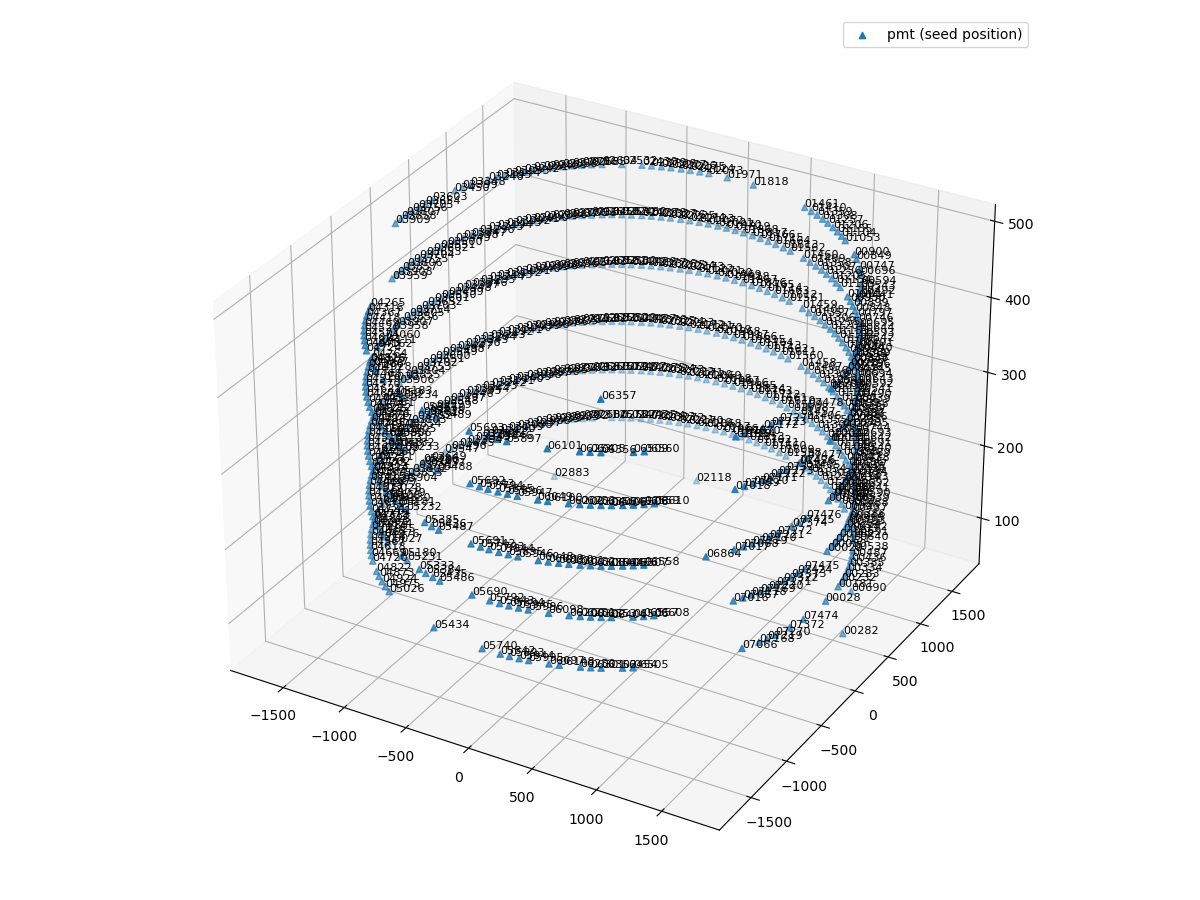

In [22]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(pmt_array[:,0], pmt_array[:,1], pmt_array[:,2], marker='^', label="pmt (seed position)")
for i, f in enumerate(pmt_locations.keys()):
    ax.text(pmt_array[i,0], pmt_array[i,1], pmt_array[i,2], f[:5], size=8, zorder=4, color='k') 
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


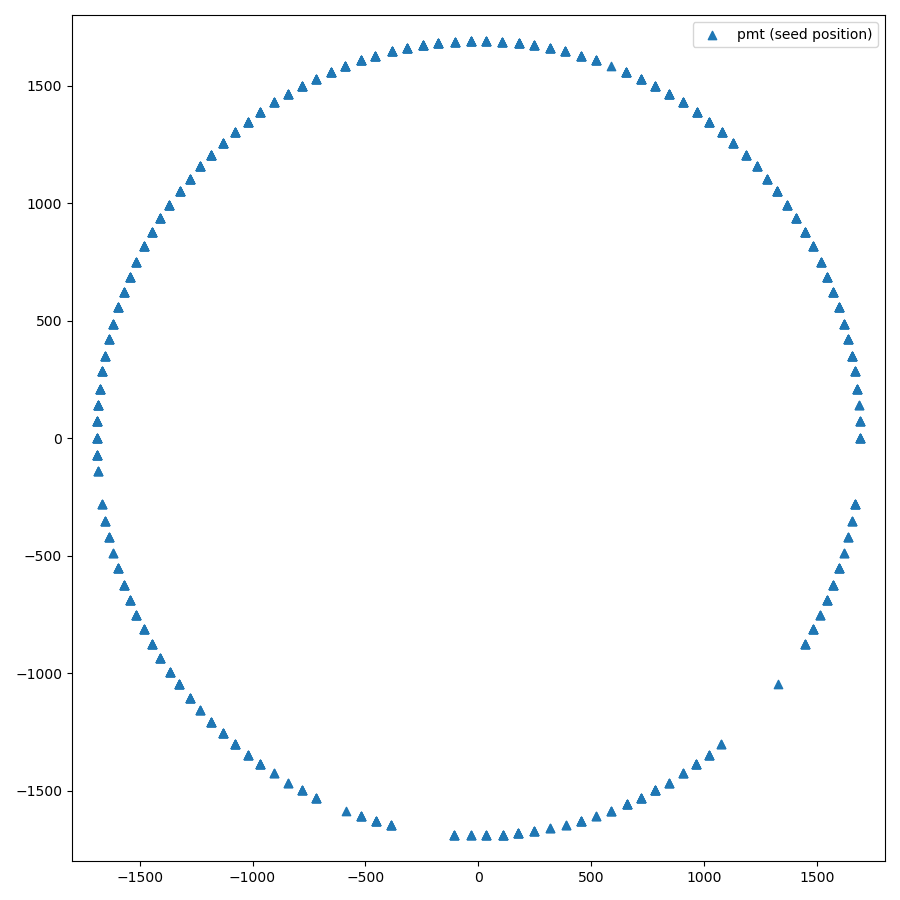

In [23]:
fig, ax = plt.subplots(figsize=(9,9))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(pmt_array[:,0], pmt_array[:,1], marker='^', label="pmt (seed position)")
ax.set_ylim((-1800,1800))
ax.set_xlim((-1800,1800))
plt.legend(loc=0)
fig.tight_layout()

## Create fitter objects

In [24]:
fitter_all = fit.PhotogrammetryFitter(common_image_feature_locations, pmt_locations,
                                       focal_length, principle_point, radial_distortion)

51 images with total of  659 features



## Estimate camera poses assuming seed feature positions

In [25]:
camera_rotations, camera_translations, reprojected_points = fitter_all.estimate_camera_poses(flags=cv2.SOLVEPNP_EPNP)


image 0 reprojection errors:    average:8.325764240666418   max: 24.339054625025327
image 1 reprojection errors:    average:10.919092165189783   max: 24.77269136082974
image 2 reprojection errors:    average:9.582962512724562   max: 19.354072931509396
image 3 reprojection errors:    average:12.044428651919704   max: 24.865349955969542
image 4 reprojection errors:    average:5.244403216477776   max: 26.305640493176867
image 5 reprojection errors:    average:5.442937098671262   max: 16.87231841531204
image 6 reprojection errors:    average:6.91847315184219   max: 32.008654232472594
image 7 reprojection errors:    average:7.9982472605108175   max: 20.3192042451039
image 8 reprojection errors:    average:24.55785135311315   max: 55.97848640819202
image 9 reprojection errors:    average:8.04199990510166   max: 34.838244202740384
image 10 reprojection errors:    average:6.3702559344246446   max: 20.107364962952317
image 11 reprojection errors:    average:6.033801001000497   max: 15.896399417

### Output a few of the features with largest errors for manual checking

In [26]:
max_err = 0
n_test = 3
im = [""]*n_test
feat = [""]*n_test
for i, ii in reprojected_points.items():
    for f, ff in ii.items():
        err = linalg.norm(ff-new_image_feature_locations[i][f])
        if err > max_err:
            for j in range(n_test-1):
                im[j+1] = im[j]
                feat[j+1] = feat[j]
            im[0] = i
            feat[0] = f
            max_err = err
for i, f in zip(im, feat):
    print(i, f, fitter_all.image_index[i], linalg.norm(reprojected_points[i][f]-new_image_feature_locations[i][f]))

771 01001-00 16 81.95220011029747
763 02531-00 8 55.97848640819202
763 02531-00 8 55.97848640819202


### Plot overlay of reprojected and observed feature locations for manual checking

<IPython.core.display.Javascript object>


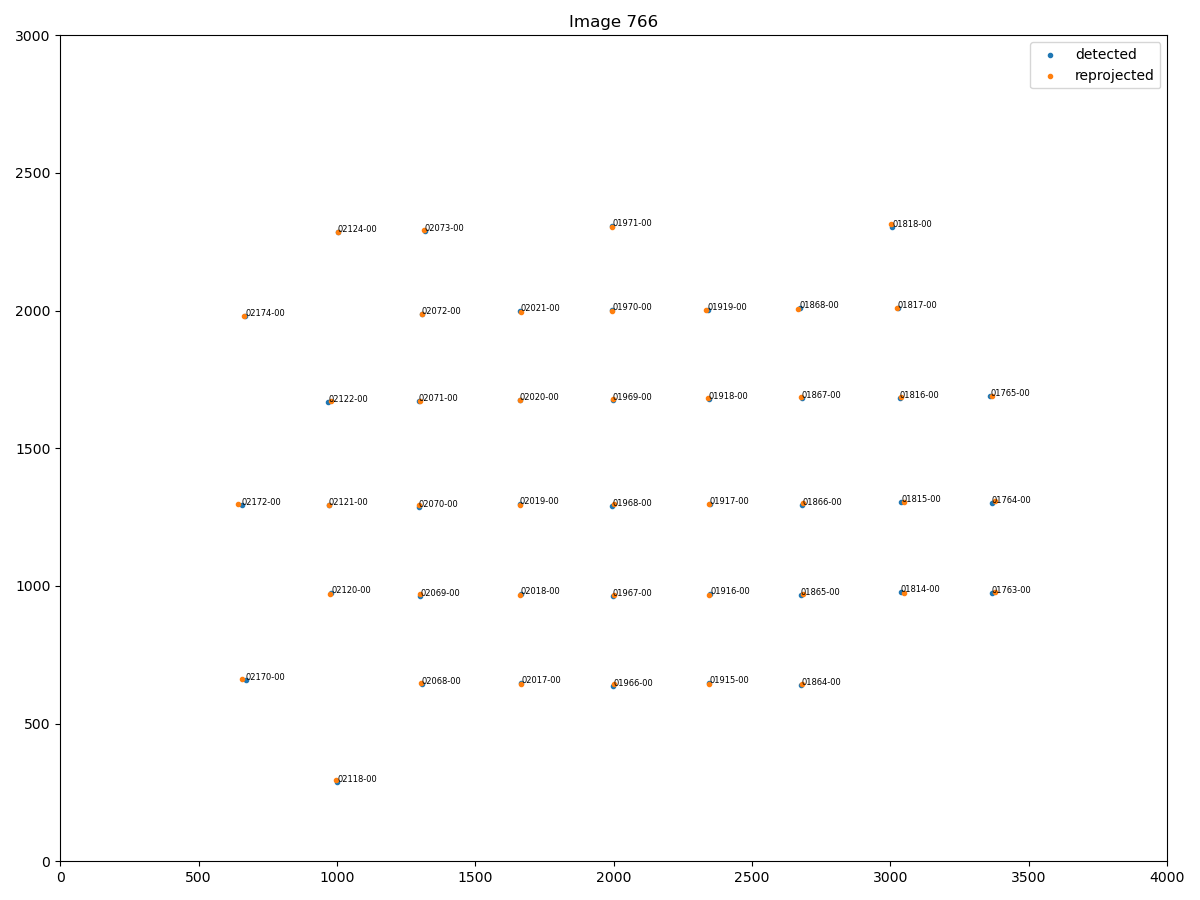

<IPython.core.display.Javascript object>


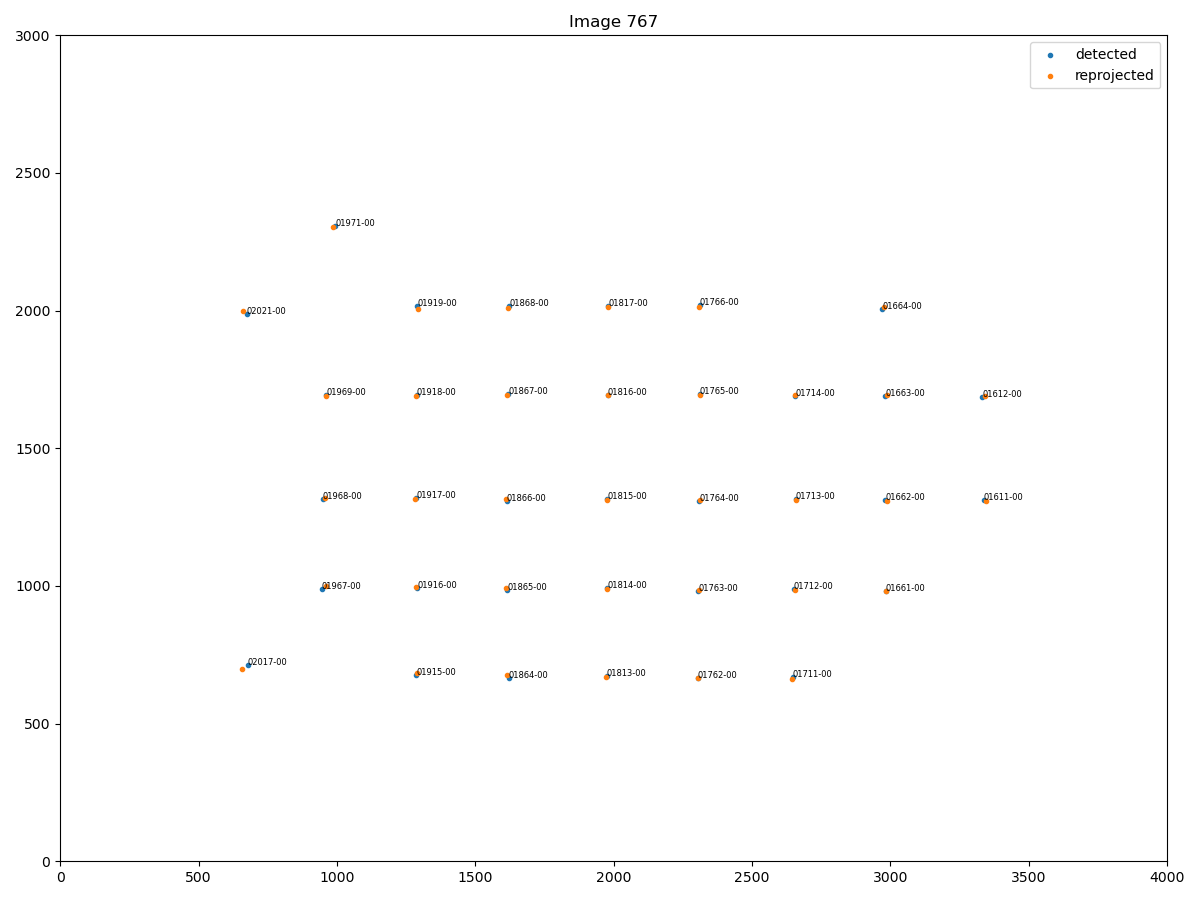

<IPython.core.display.Javascript object>


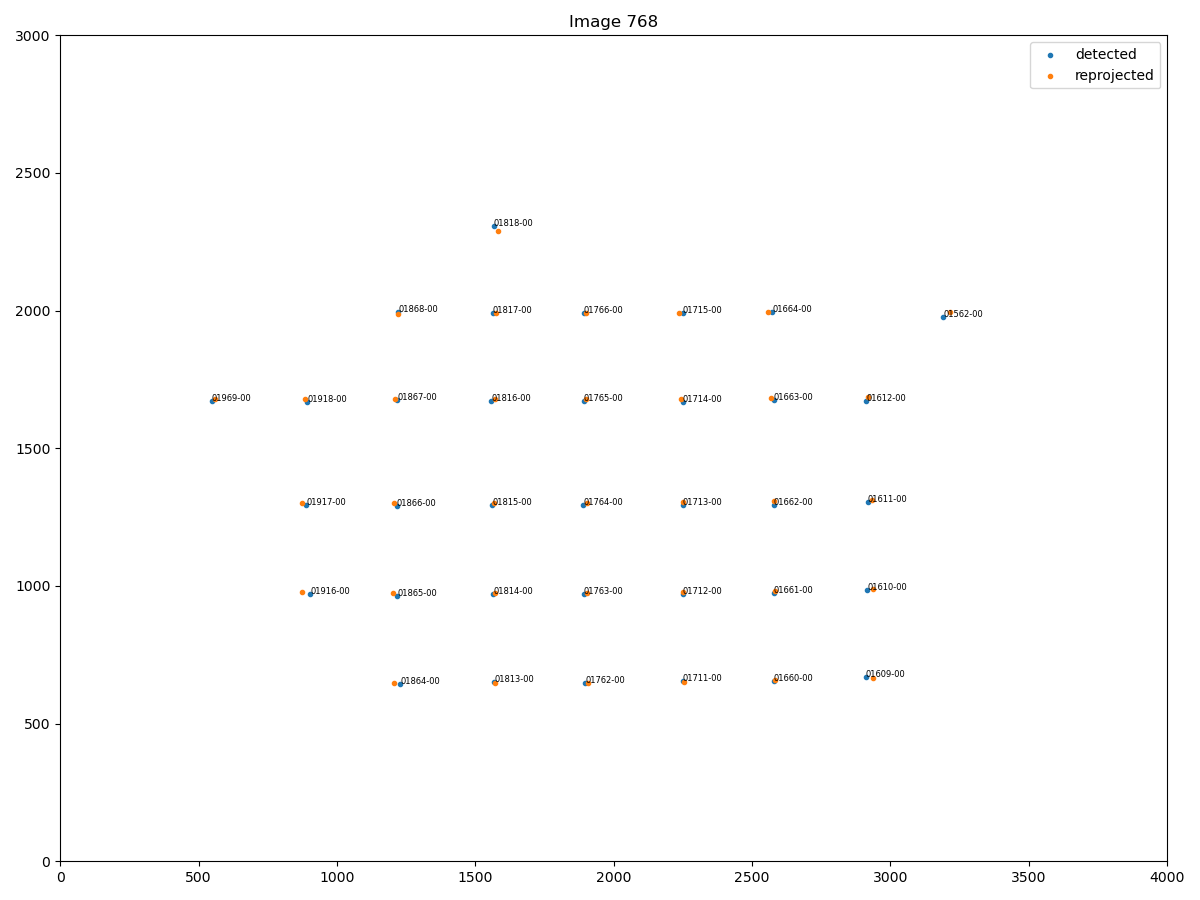

<IPython.core.display.Javascript object>


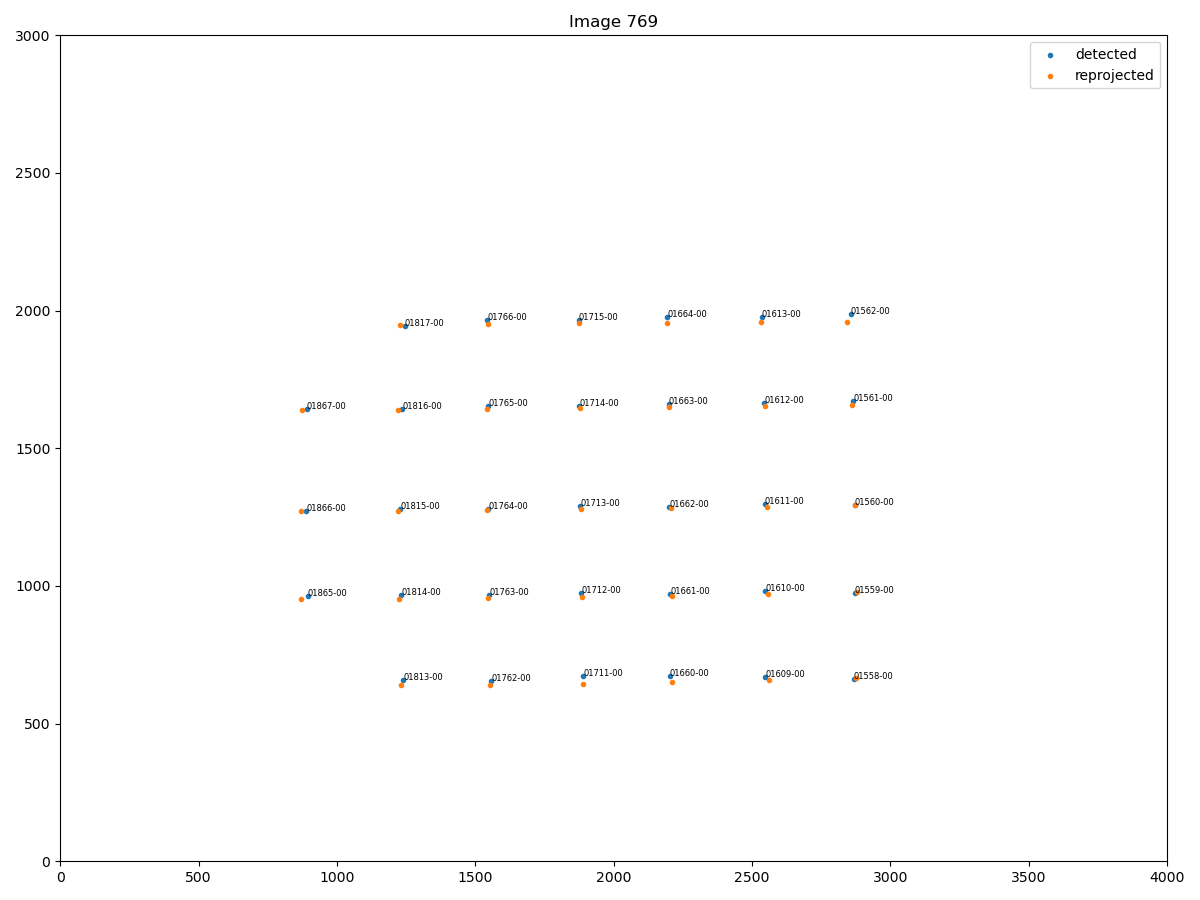

In [27]:
for test_image in ['766', '767', '768', '769']:
    fig, ax = plt.subplots(figsize=(12,9))
    coords = np.stack(list(common_image_feature_locations[test_image].values()))
    repro_coords = np.stack(list(reprojected_points[test_image].values()))
    ax.scatter(coords[:,0], 3000-coords[:,1], marker='.', label='detected')
    ax.scatter(repro_coords[:,0], 3000-repro_coords[:,1], marker='.', label='reprojected')
    for t, f in common_image_feature_locations[test_image].items():
        ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='k')
#    for t, f in reprojected_points[fitter_pmts.index_image[test_image]].items():
#        ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='gray')
    ax.set_title("Image {}".format(test_image))
    ax.set_ylim(0, 3000)
    ax.set_xlim(0, 4000)
    plt.legend(loc=0)
    fig.tight_layout()
    plt.savefig(saveLocation+"initial_estimate/image_plots/"+test_image+"-initial_estimate-plot"+imageExtension)

### Plot camera position estimates in 3D

<IPython.core.display.Javascript object>


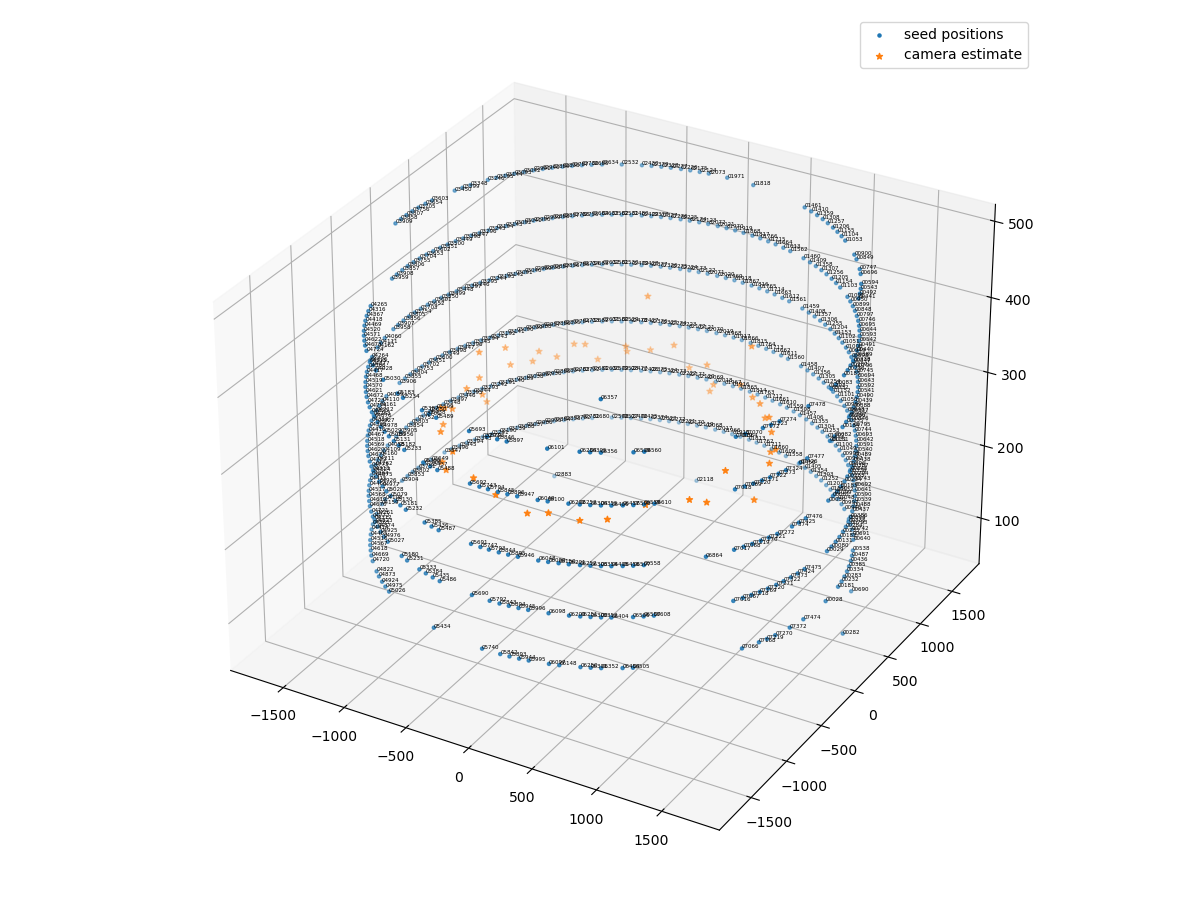

In [28]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
fig = plt.figure(figsize=(12,9))
pmt_array = np.stack(list(pmt_locations.values()))
feat_array = np.stack(list(pmt_locations.values()))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feat_array[:,0], feat_array[:,1], feat_array[:,2], marker='.', label="seed positions", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(pmt_array[i,0], pmt_array[i,1], pmt_array[i,2], f[:5], size=4, zorder=4, color='k') 
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera estimate", zorder=1)
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


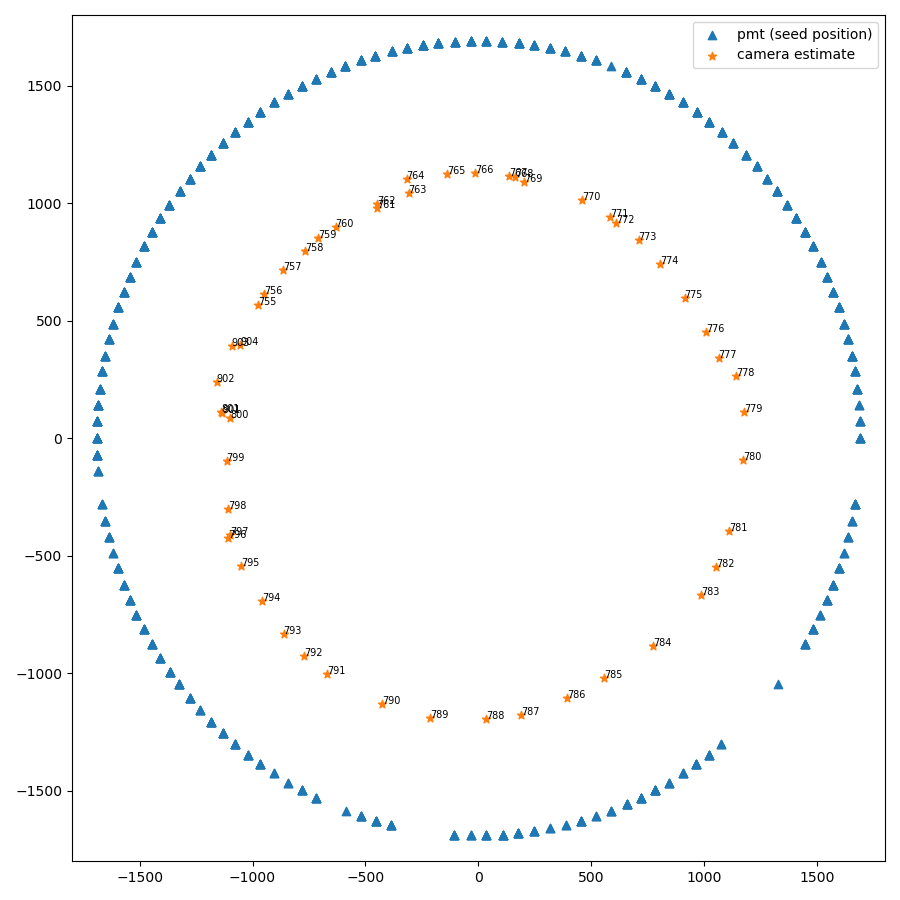

In [29]:
fig, ax = plt.subplots(figsize=(9,9))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(pmt_array[:,0], pmt_array[:,1], marker='^', label="pmt (seed position)")
ax.scatter(camera_positions[:,0], camera_positions[:,1], marker='*', label="camera estimate", zorder=1)
for i, p in enumerate(camera_positions):
    ax.text(p[0], p[1], fitter_all.index_image[i], size=7, zorder=4, color='k') 
ax.set_ylim((-1800,1800))
ax.set_xlim((-1800,1800))
plt.legend(loc=0)
fig.tight_layout()
fig.savefig(saveLocation+"initial_estimate/initial_estimate-top"+imageExtension)

<IPython.core.display.Javascript object>


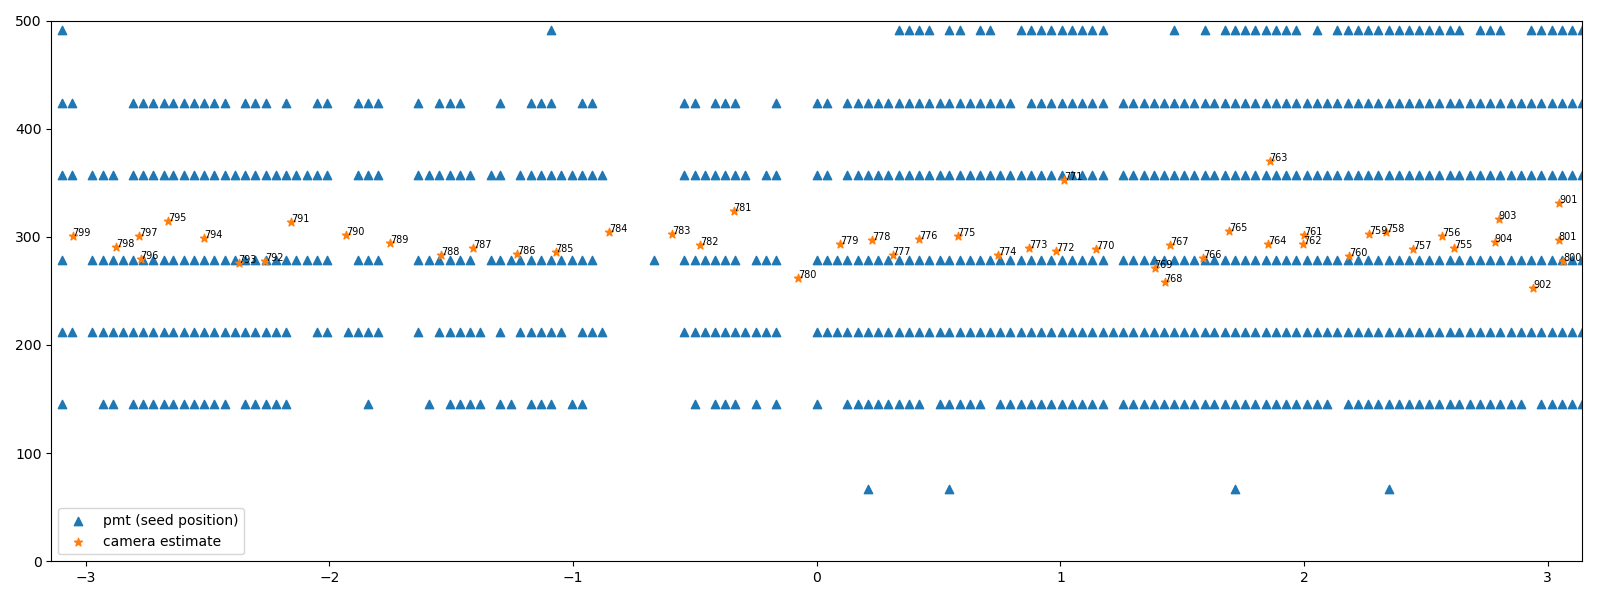

In [30]:
fig, ax = plt.subplots(figsize=(16,6))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(np.arctan2(pmt_array[:,1],pmt_array[:,0]), pmt_array[:,2], marker='^', label="pmt (seed position)")
ax.scatter(np.arctan2(camera_positions[:,1], camera_positions[:,0]), camera_positions[:,2], marker='*', label="camera estimate", zorder=1)
for i, p in enumerate(camera_positions):
    ax.text(np.arctan2(p[1],p[0]), p[2], fitter_all.index_image[i], size=7, zorder=4, color='k') 
ax.set_xlim((-np.pi,np.pi))
ax.set_ylim((0,500))
plt.legend(loc=0)
fig.tight_layout()
fig.savefig(saveLocation+"initial_estimate/initial_estimate-barrel"+imageExtension)

## Perform bundle asjustment starting from seed geometry and estimated camera poses

In [31]:
# camera_rotations, camera_translations, reco_locations, fitted_matrix, fitted_distortion = fitter_all.bundle_adjustment(
#     camera_rotations, camera_translations, use_sparsity=True, max_error=5, fit_cam=True)
camera_rotations, camera_translations, reco_locations = fitter_all.bundle_adjustment(camera_rotations, camera_translations, use_sparsity=True)
#camera_rotations, camera_translations, reco_locations = fitter_all.bundle_adjustment(camera_rotations, camera_translations, use_sparsity=True, max_error=10)
#camera_rotations, camera_translations, reco_locations = fitter_all.bundle_adjustment(camera_rotations, camera_translations, use_sparsity=True, max_error=5)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3424e+05                                    3.70e+06    
       1              2         3.7790e+04      9.65e+04       7.24e+01       3.02e+04    
       2              3         3.3121e+04      4.67e+03       4.49e+01       2.22e+04    
       3              4         3.1158e+04      1.96e+03       1.20e+01       4.88e+03    
       4              5         3.0787e+04      3.71e+02       5.12e+00       3.66e+03    
       5              6         3.0465e+04      3.22e+02       3.73e+00       5.28e+03    
       6              7         3.0335e+04      1.30e+02       1.64e+00       2.11e+03    
       7              8         3.0236e+04      9.97e+01       1.45e+00       3.78e+03    
       8              9         3.0140e+04      9.52e+01       1.39e+00       1.86e+03    
       9             10         3.0048e+04      9.24e+01       1.37e+00       3.44e+03    

## Kabsch algorithm to match reconstructed coordinate system to seed co-ordinate system

In [32]:
errors, reco_transformed, scale, R, translation, location_mean = fit.kabsch_errors(pmt_locations, reco_locations)
print("mean reconstruction error:", linalg.norm(errors, axis=1).mean())
print("max reconstruction error:", linalg.norm(errors, axis=1).max())

mean reconstruction error: 3.7315101203047174
max reconstruction error: 17.477164354546154


In [33]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
camera_orientations = np.matmul(R, camera_orientations)
camera_positions = camera_positions - translation
camera_positions = scale*R.dot(camera_positions.transpose()).transpose() + location_mean

## Check new yaws and depths for manual shifts if necessary

In [34]:
drone_yaw = np.array(list(drone_yaw_raw.values()))*np.pi/180
fitted_yaw = np.arctan2(camera_orientations[:,1,2],camera_orientations[:,0,2])
drone_yaw -= drone_yaw[21] - fitted_yaw[21] # correct for drone calibration by forcing image 21 (with light injector) to have the correct yaw
yaw_errors = ((fitted_yaw - drone_yaw + np.pi) % (2*np.pi)) - np.pi
yaw_errors_deg = yaw_errors*180/np.pi
depths = camera_positions[:,2]/100 - 2.9

<IPython.core.display.Javascript object>


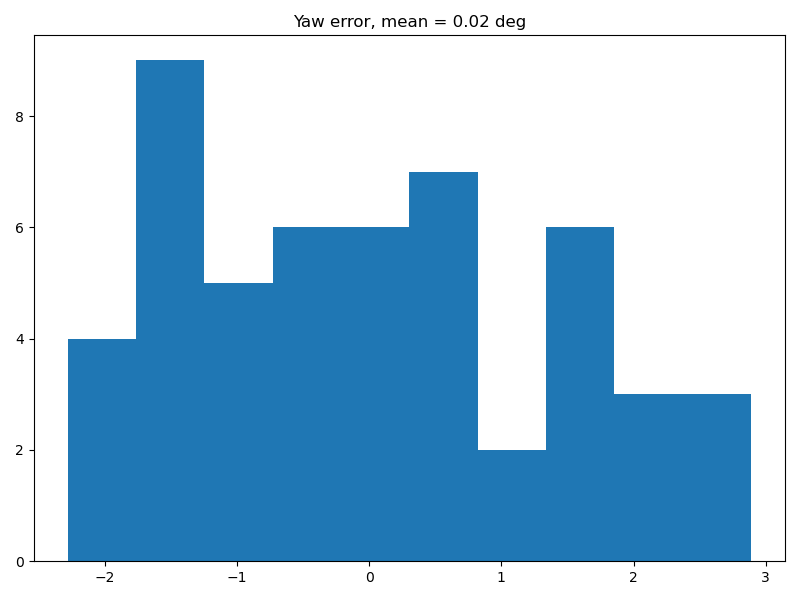

               yaw    depth
image 755: -1.0703  +0.0258
image 756: +1.9482  +0.0888
image 757: +0.4014  +0.0010
image 758: -1.3159  +0.1232
image 759: +1.4662  +0.1017
image 760: -0.7969  -0.0727
image 761: -0.1091  +0.0986
image 762: +0.6869  +0.0295
image 763: -0.2685  +0.6528
image 764: +1.5915  +0.0833
image 765: +0.8007  +0.1463
image 766: -1.4092  -0.0841
image 767: -2.2807  +0.0160
image 768: -0.1982  -0.2781
image 769: +0.3343  -0.1836
image 770: -0.8805  +0.0172
image 771: -0.5638  +0.5047
image 772: +0.4240  +0.0093
image 773: -0.1289  -0.0132
image 774: -0.9767  -0.0692
image 775: +1.2496  +0.1073
image 776: +0.0000  +0.0766
image 777: -1.2644  -0.0580
image 778: +0.6659  +0.0648
image 779: +2.4704  +0.0414
image 780: -0.9931  -0.2647
image 781: -1.2674  +0.3156
image 782: +2.2404  +0.0291
image 783: +1.5014  +0.1269
image 784: -0.1472  +0.1419
image 785: -1.3680  -0.0395
image 786: +1.7424  -0.0543
image 787: -1.7838  +0.0016
image 788: +2.8878  -0.0582
image 789: +2.8111  

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(yaw_errors_deg, bins=10)
ax.set_title(f"Yaw error, mean = {yaw_errors_deg.mean():.2f} deg")
fig.tight_layout()
print("               yaw    depth")
for i, (e, d) in enumerate(zip(yaw_errors_deg, depths)):
    print(f"image {fitter_all.index_image[i]}: {e:+6.4f}  {d:+6.4f}")

### Plot overlay of reprojected and observed feature locations for manual checking

<IPython.core.display.Javascript object>


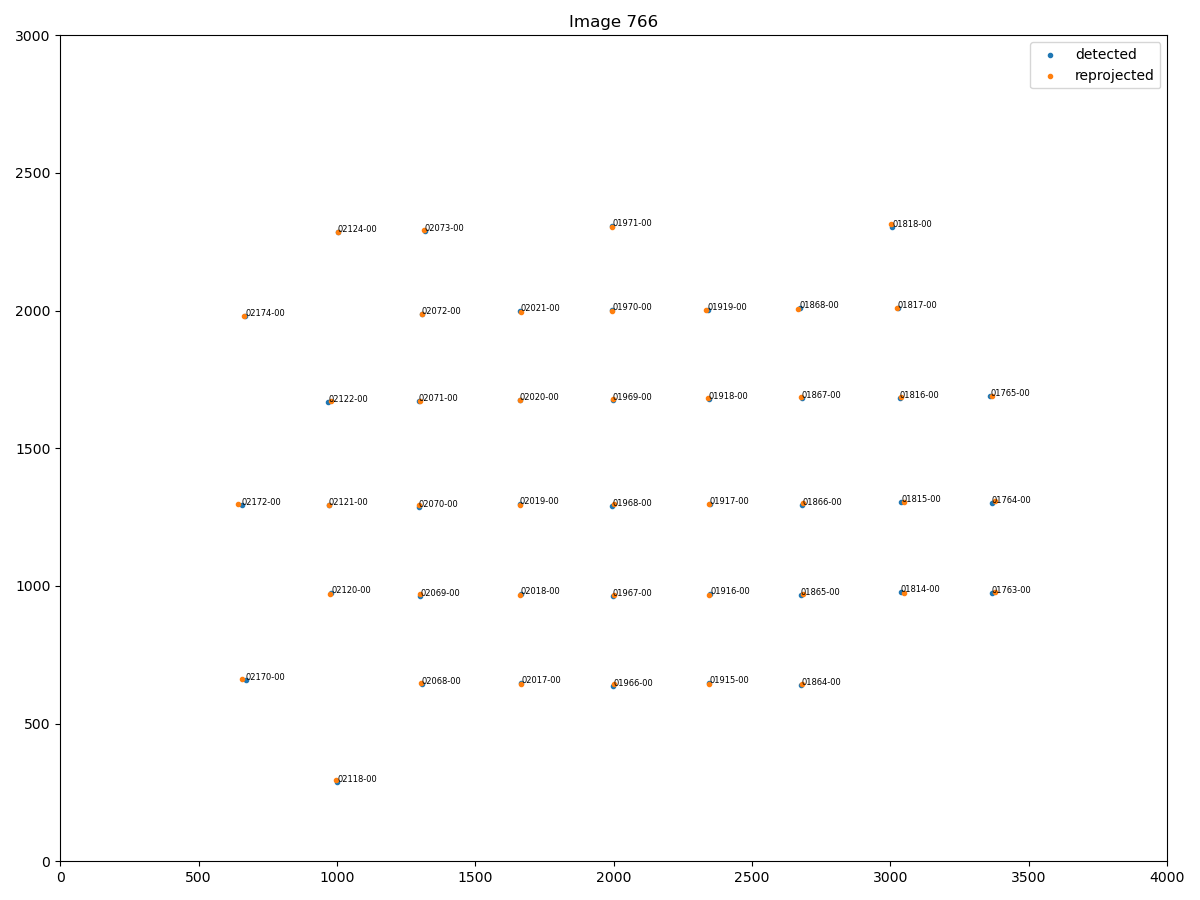

<IPython.core.display.Javascript object>


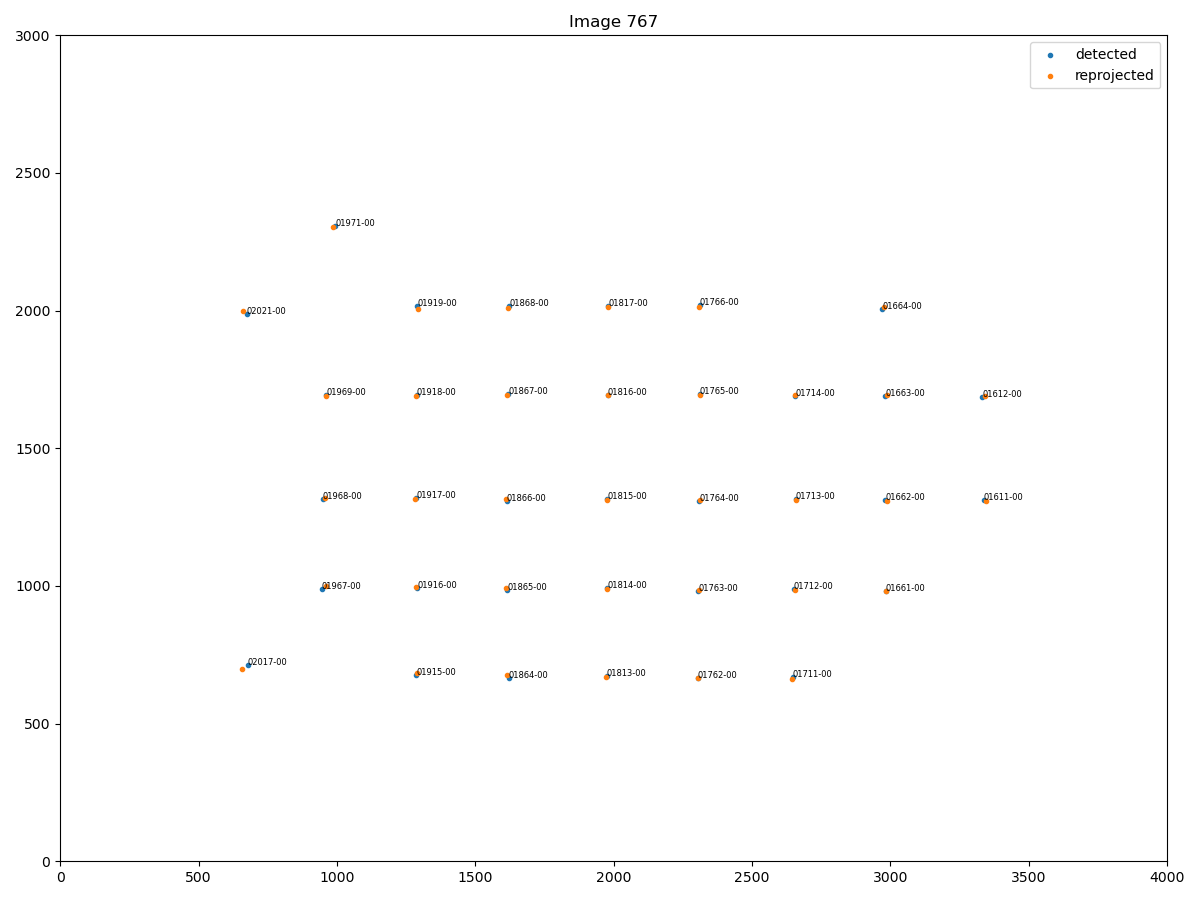

<IPython.core.display.Javascript object>


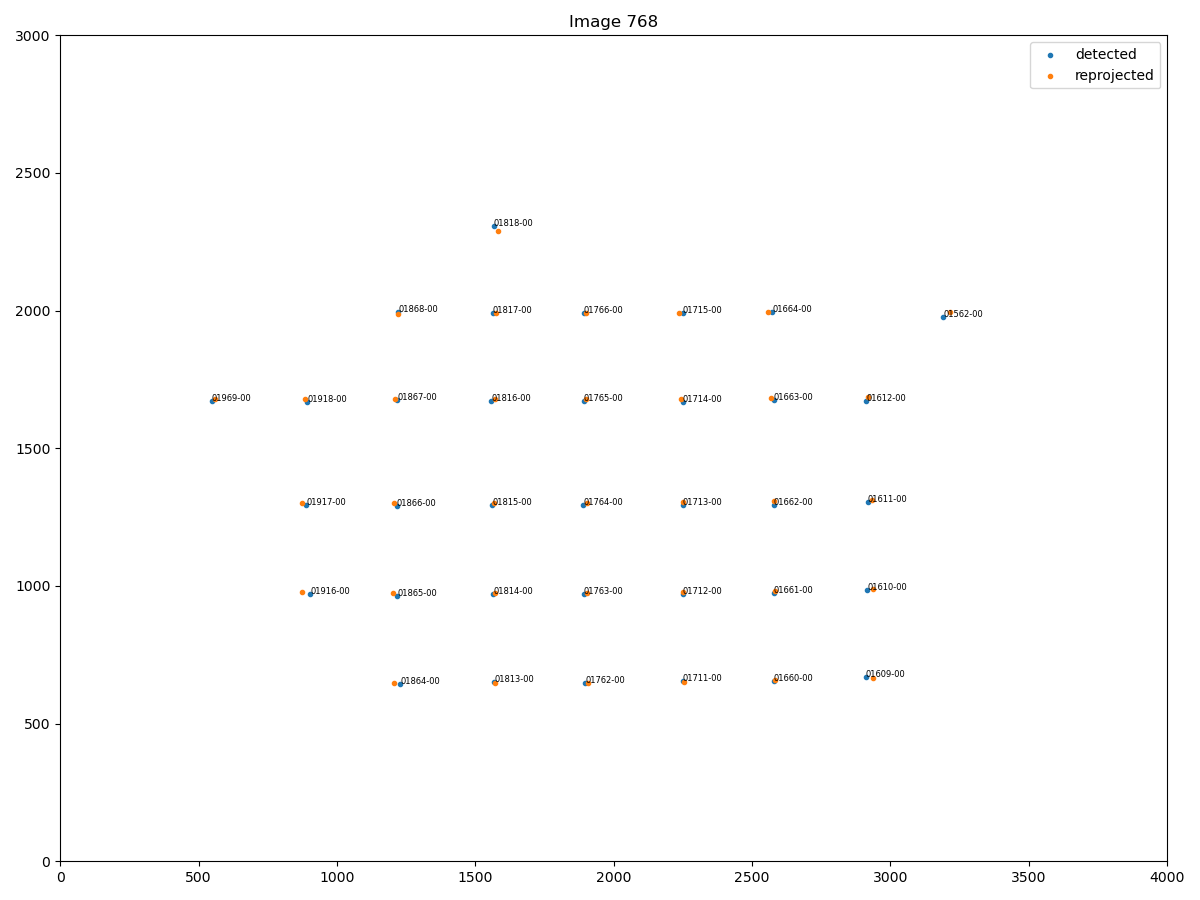

<IPython.core.display.Javascript object>


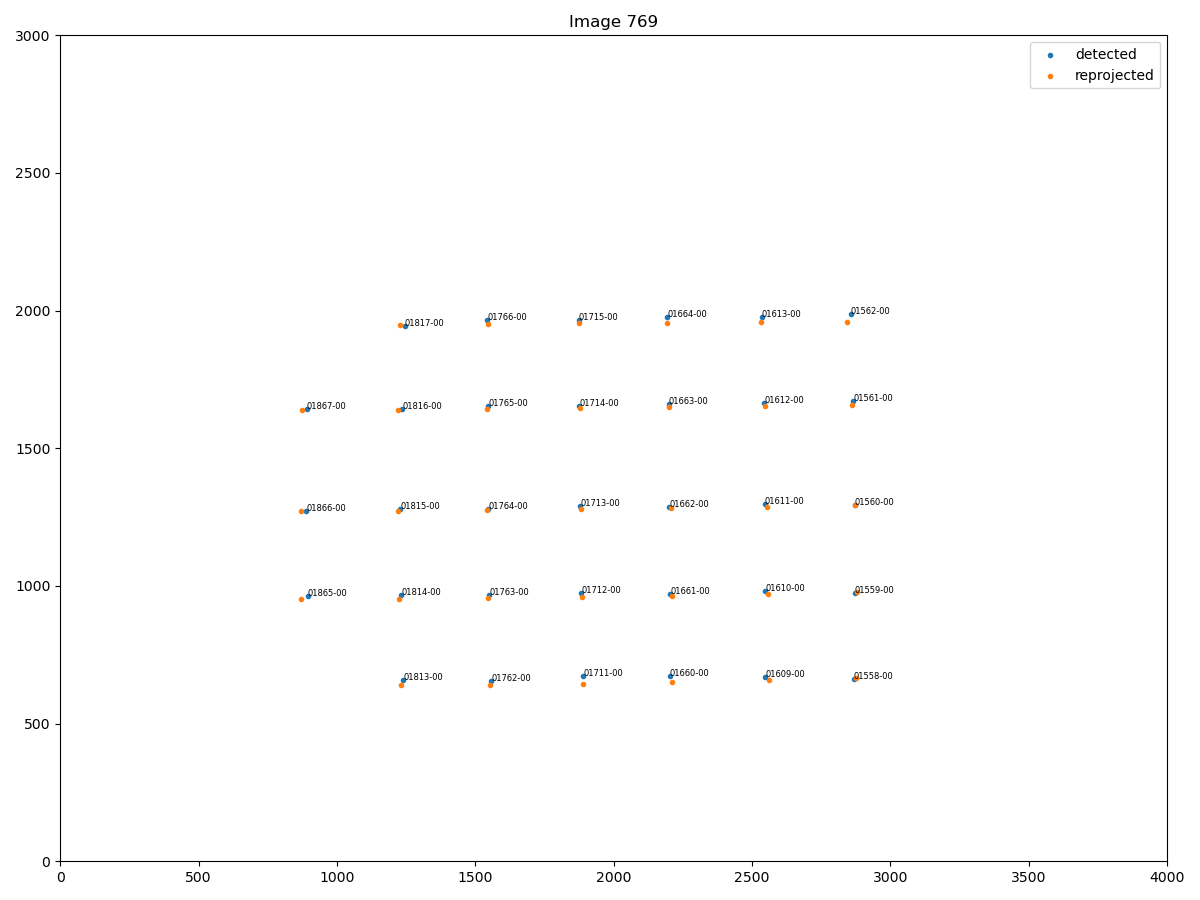

In [36]:
for test_image in ['766', '767', '768', '769']:
    fig, ax = plt.subplots(figsize=(12,9))
    coords = np.stack(list(common_image_feature_locations[test_image].values()))
    repro_coords = np.stack(list(reprojected_points[test_image].values()))
    ax.scatter(coords[:,0], 3000-coords[:,1], marker='.', label='detected')
    ax.scatter(repro_coords[:,0], 3000-repro_coords[:,1], marker='.', label='reprojected')
    for t, f in common_image_feature_locations[test_image].items():
        ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='k')
#    for t, f in reprojected_points[fitter_pmts.index_image[test_image]].items():
#        ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='gray')
    ax.set_title("Image {}".format(test_image))
    ax.set_ylim(0, 3000)
    ax.set_xlim(0, 4000)
    plt.legend(loc=0)
    fig.tight_layout()
    plt.savefig(saveLocation+"image_plots/"+test_image+"-plot"+imageExtension)

## Save results to txt file

In [37]:
fitter_all.save_result(saveLocation+"SK_ring_features_relabelled.txt", saveLocation+"SK_ring_cameras_relabelled.txt")

## Save results to pickle

In [38]:
with open(saveLocation+"SK_ring_relabelled.pkl", 'wb') as output:
    pickle.dump(fitter_all, output, pickle.HIGHEST_PROTOCOL)

## Plots of reconstructed geometry

In [39]:
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
class HandlerArrow(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        p = mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.75*height )
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

<IPython.core.display.Javascript object>


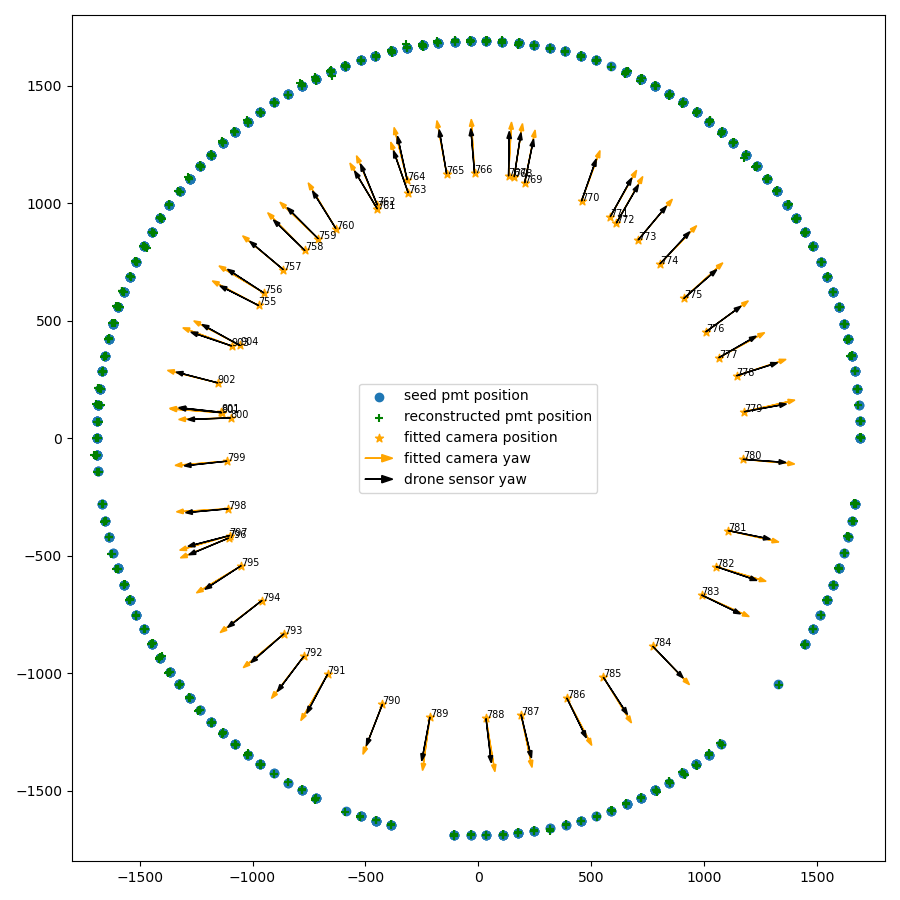

In [40]:
fig, ax = plt.subplots(figsize=(9,9))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(pmt_array[:,0], pmt_array[:,1], marker='o', label="seed pmt position")
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], marker='+', label="reconstructed pmt position", color="green")
ax.scatter(camera_positions[:,0], camera_positions[:,1], marker='*', label="fitted camera position", zorder=1, color="orange")
for i, p in enumerate(camera_positions):
    ax.text(p[0], p[1], fitter_all.index_image[i], size=7, zorder=4, color='k')
for i, (p, o) in enumerate(zip(camera_positions, camera_orientations)):
    fitarrow = plt.arrow(p[0], p[1], o[0,2]*200, o[1,2]*200, color="orange", width=0.1, head_width=20, head_length=30)
for i, (p, y) in enumerate(zip(camera_positions, drone_yaw)):
    dronearrow = plt.arrow(p[0], p[1], np.cos(y)*160, np.sin(y)*160, color="black", width=0.01, head_width=20, head_length=30)
ax.set_ylim((-1800,1800))
ax.set_xlim((-1800,1800))
handles, labels = ax.get_legend_handles_labels()
handles.extend((fitarrow, dronearrow))
labels.extend(("fitted camera yaw", "drone sensor yaw"))
plt.legend(handles=handles, labels=labels, loc=0, handler_map={mpatches.FancyArrow : HandlerArrow()})
fig.tight_layout()
fig.savefig(saveLocation+"top"+imageExtension)

<IPython.core.display.Javascript object>


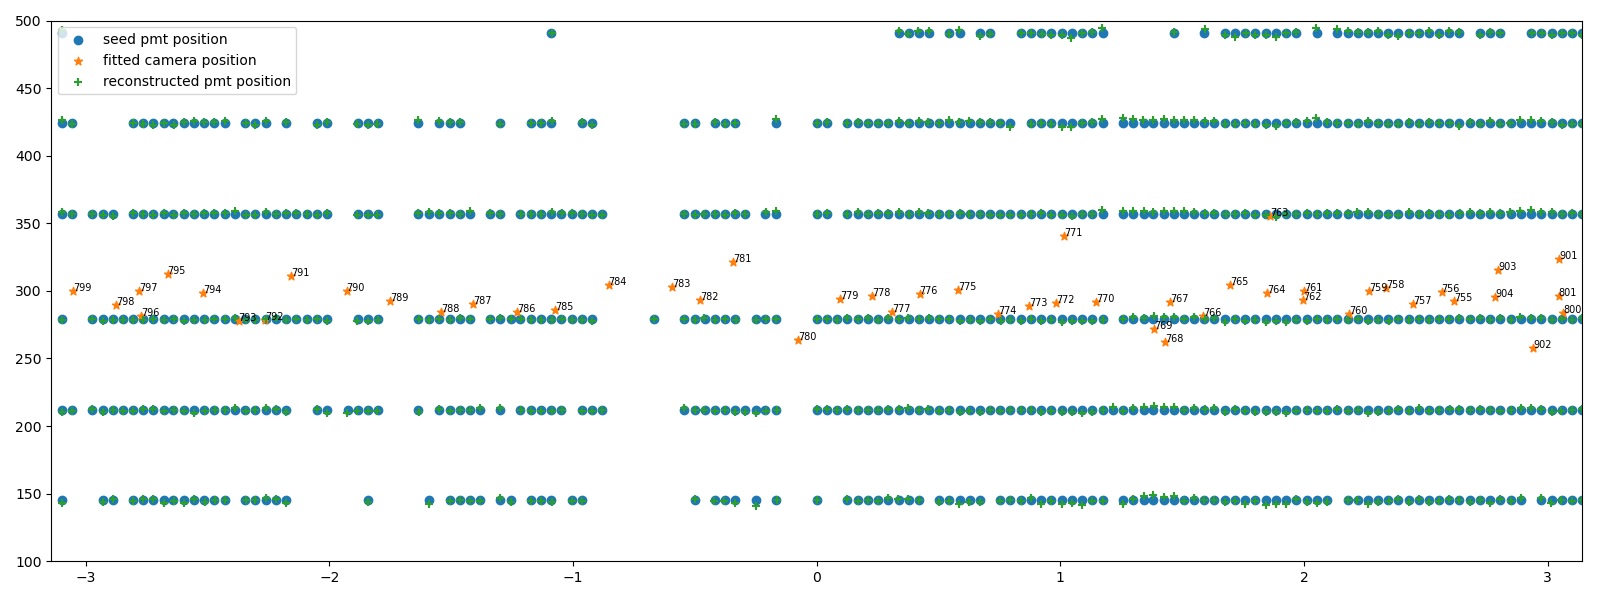

In [41]:
fig, ax = plt.subplots(figsize=(16,6))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(np.arctan2(pmt_array[:,1],pmt_array[:,0]), pmt_array[:,2], marker='o', label="seed pmt position")
ax.scatter(np.arctan2(camera_positions[:,1], camera_positions[:,0]), camera_positions[:,2], marker='*', label="fitted camera position", zorder=1)
ax.scatter(np.arctan2(reco_transformed[:,1], reco_transformed[:,0]), reco_transformed[:,2], marker='+', label="reconstructed pmt position")
for i, p in enumerate(camera_positions):
    ax.text(np.arctan2(p[1],p[0]), p[2], fitter_all.index_image[i], size=7, zorder=4, color='k') 
ax.set_xlim((-np.pi,np.pi))
ax.set_ylim((100,500))
plt.legend(loc=0)
fig.tight_layout()
fig.savefig(saveLocation+"barrel"+imageExtension)

<IPython.core.display.Javascript object>


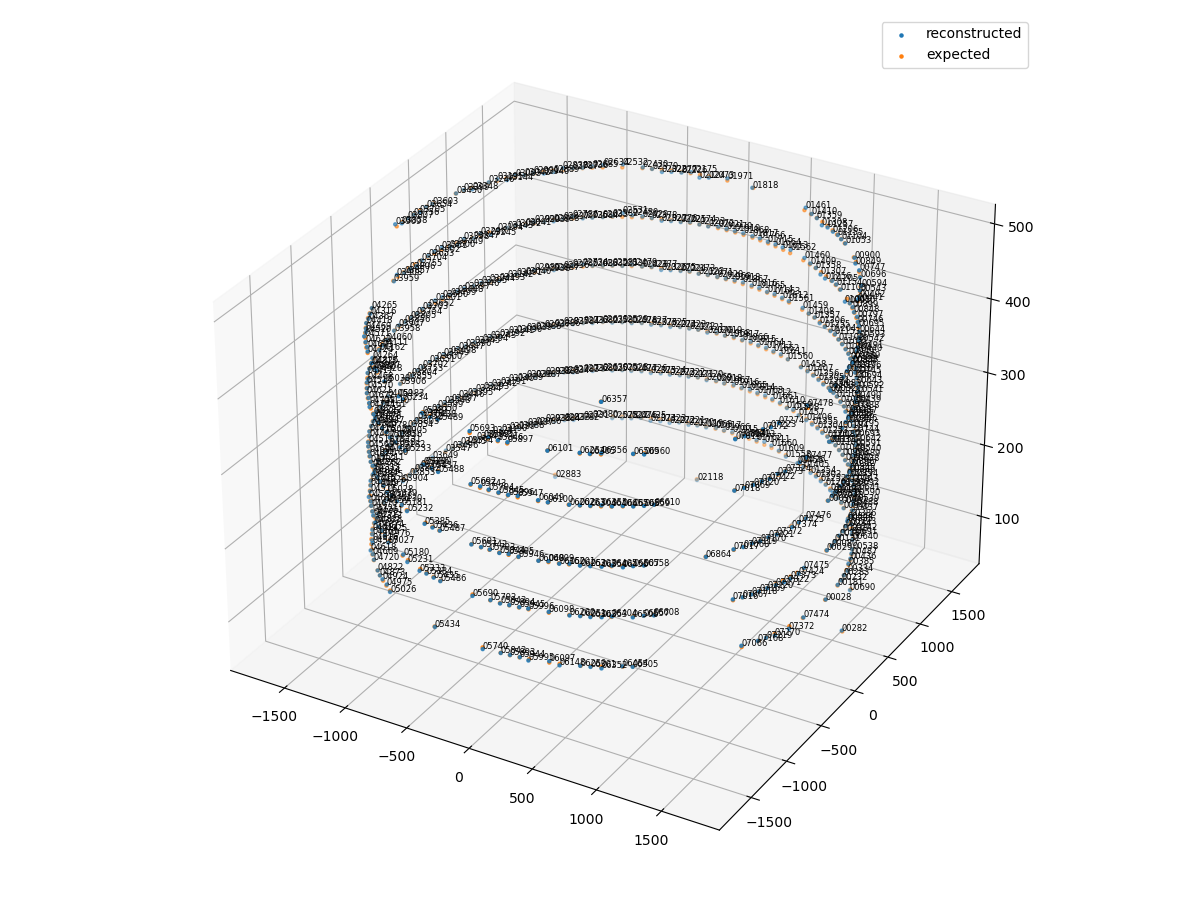

In [42]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="reconstructed", zorder=3)
ax.scatter(pmt_array[:,0], pmt_array[:,1], pmt_array[:,2], marker='.', label="expected", zorder=2)
for f in pmt_locations.keys():
    i = fitter_all.feature_index[f]
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=6, zorder=4, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)
fig.tight_layout()

## Plot reprojection errors

<IPython.core.display.Javascript object>


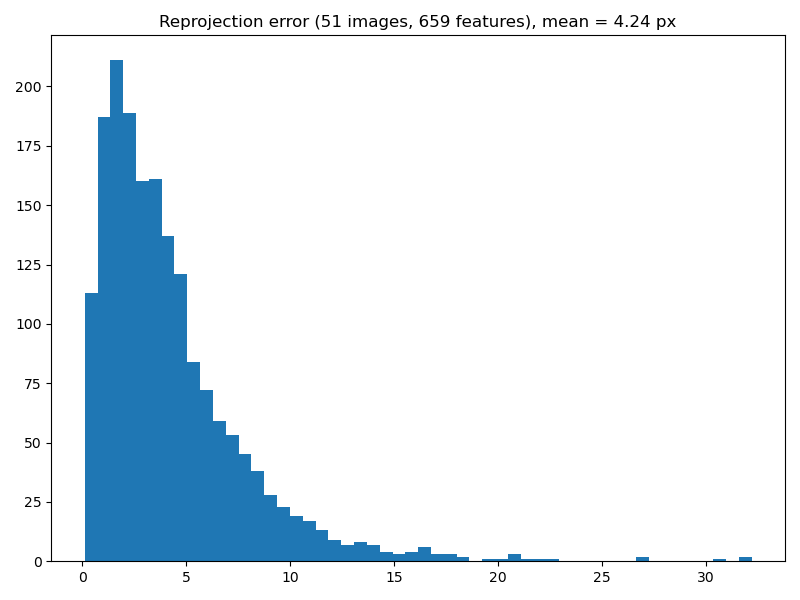

In [43]:
fig, ax = plt.subplots(figsize=(8,6))
reprojection_errors = fitter_all.reprojection_errors(fitter_all.camera_rotations, fitter_all.camera_translations, fitter_all.reco_locations)
reprojection_errors = linalg.norm(reprojection_errors.reshape((-1,2)), axis=1)
ax.hist(reprojection_errors, bins='auto')
ax.set_title("Reprojection error ({} images, {} features), mean = {:.2f} px".format(
    nimages, nfeatures, reprojection_errors.mean()))
fig.tight_layout()
fig.savefig(saveLocation+"reprojection error.png")

In [44]:
# Sort the images/features by highest reprojection errors, for manual checking
print(np.array(np.unravel_index(np.argsort(linalg.norm(fitter_all.reprojected_locations()-fitter_all.image_feature_locations, axis=2).ravel()), (nimages, nfeatures))))
print(linalg.norm(fitter_all.reprojected_locations()-fitter_all.image_feature_locations, axis=2)[1, 90])
print(fitter_all.index_feature[3])

[[  0  33  33 ...  18  16  49]
 [  0 370 369 ... 633 212  68]]
0.0
01813-00


## Plots of differences between expected and reconstructed geometry

<IPython.core.display.Javascript object>


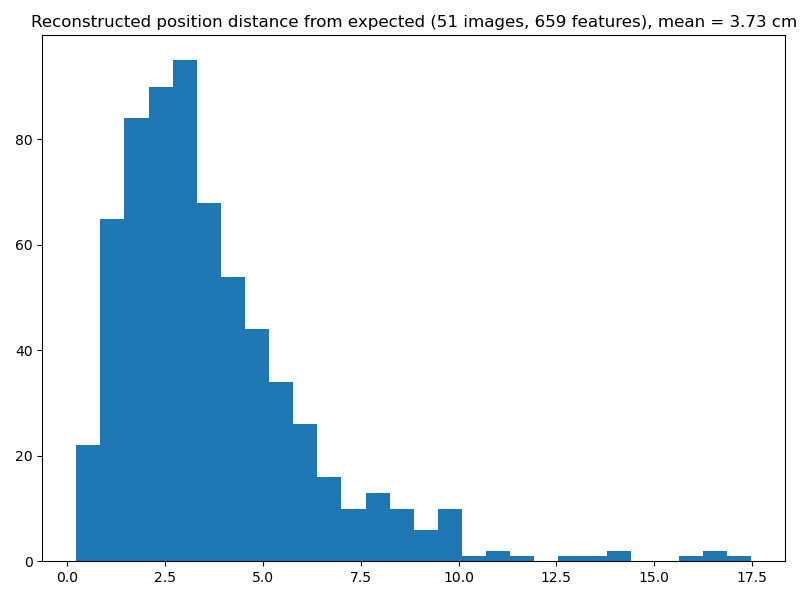

In [45]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(linalg.norm(errors, axis=1), bins='auto')
ax.set_title("Reconstructed position distance from expected ({} images, {} features), mean = {:.2f} cm".format(
    nimages, nfeatures, linalg.norm(errors, axis=1).mean()))
fig.tight_layout()
fig.savefig(saveLocation+"distance from expected.png")

# End.